In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

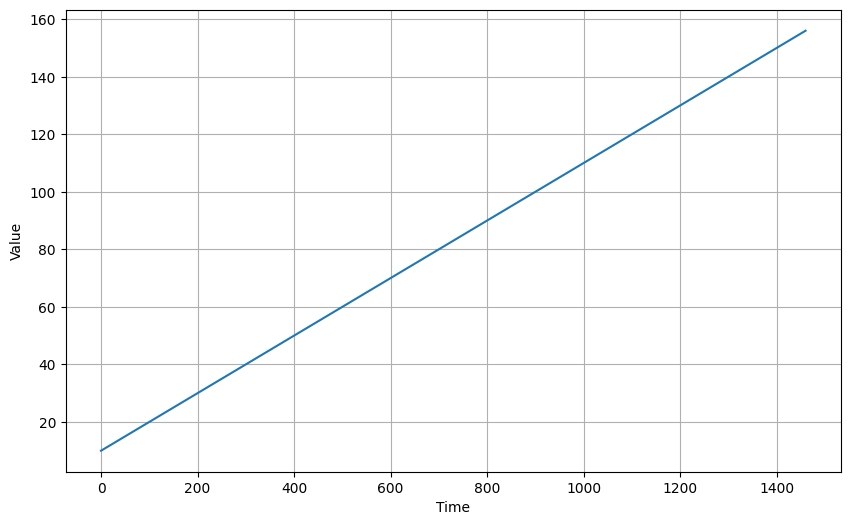

In [3]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [5]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

In [6]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

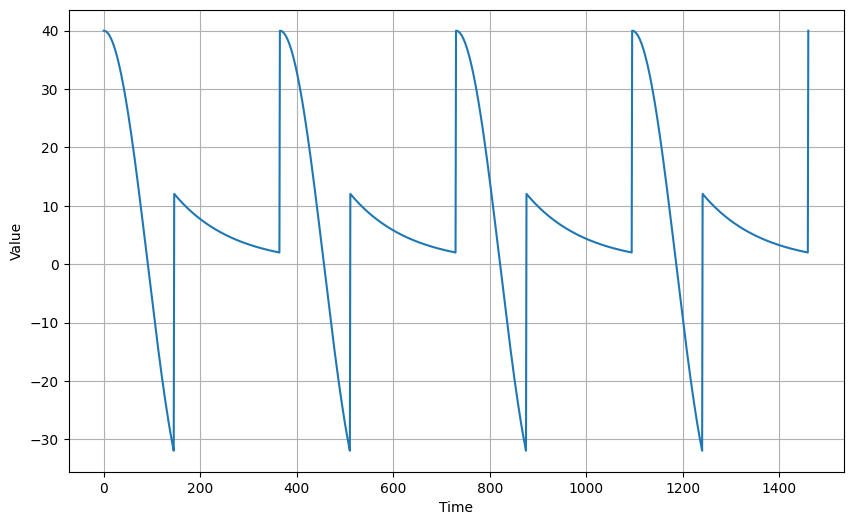

In [7]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

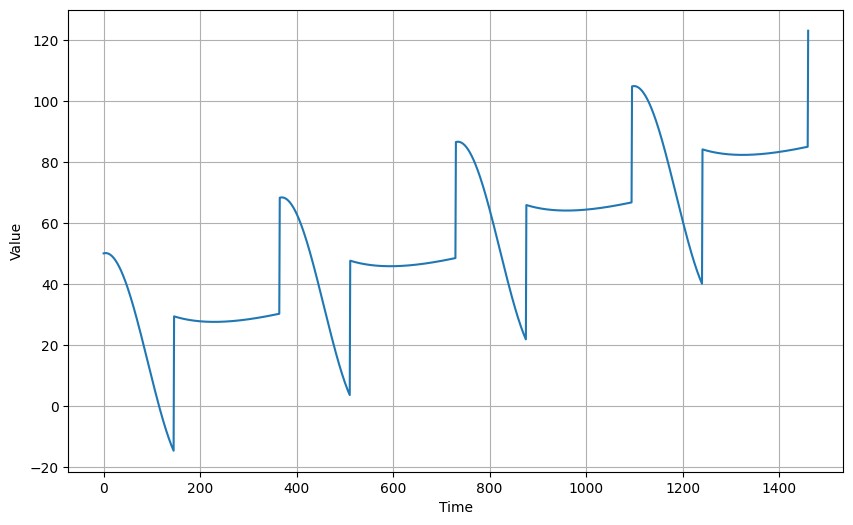

In [8]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [9]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

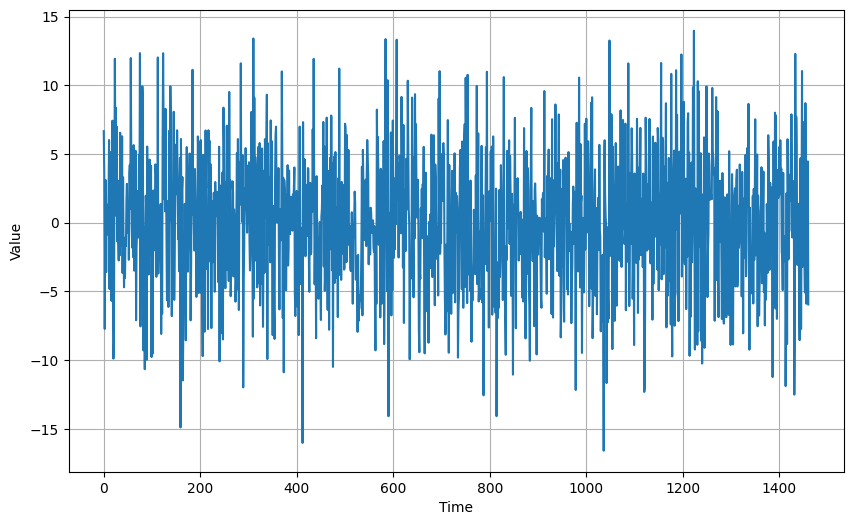

In [28]:
noise_level = 5
noise = white_noise(time, noise_level, seed=10)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

In [29]:
noise

array([ 6.65793252,  3.57639487, -7.72700146, ..., -4.20987046,
        4.46113778, -5.94911467])

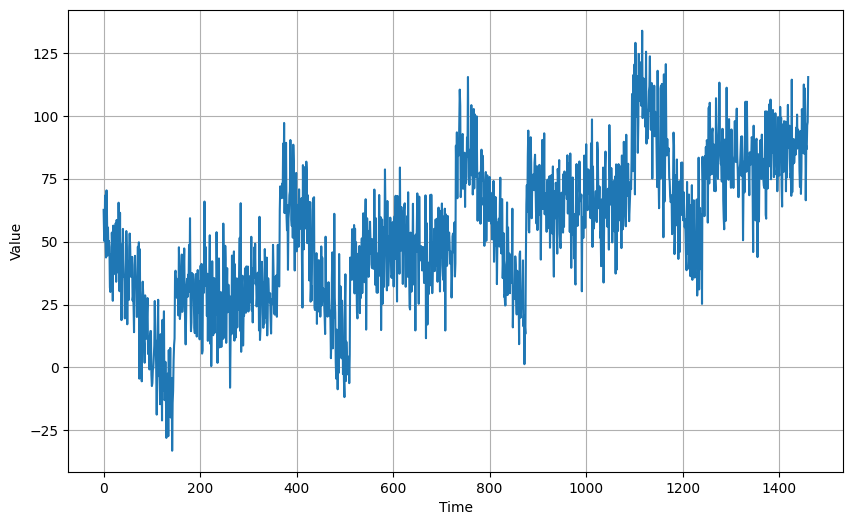

In [30]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()